In [1]:
import glob
import os
import datetime as dt
import numpy as np
import pandas as pd

# Google Colab settings 
# nltk.download('stopwords')
# nltk.download('wordnet')
# !pip install vaderSentiment
# nltk.download('vader_lexicon')

from pathlib import Path
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from textblob import TextBlob

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_i_a = SentimentIntensityAnalyzer()
from nltk.sentiment.util import *
from tqdm import tqdm

In [69]:
# Choose the handler to use.
currency = [
    # "DOGE"
    "BTC",
]

class process_tweets():

    def __init__(self, tokenizer=None, stop_words=None, stemmer=None, lemmatizer=None):
        """ 
        Initialize the class.
        """
        # Google Colab settings. 
        # self.path = "/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/Market-prediction"

        self.path = Path(f'{os.getcwd()}/market_prediction')
        self.tokenizer = tokenizer
        self.stop_words = stop_words
        self.stemmer = stemmer
        self.lemmatizer = lemmatizer

        self.df = []
        self.vocabulary = []
        self.final = []


    # Read tweets from CSV for every currency
    def read_tweets(self, curr):
        """
        Read the tweets from the CSV file.
        """
        aux = []
        ret = pd.DataFrame()
        count = 0
        for file in glob.glob(f"{self.path}/2022-*-{curr}-*.csv"):
            print(f"Reading {file}")
            ret = pd.concat([pd.read_csv(file)], ignore_index=True)
            ret['coin_type'] = curr
            aux.append(ret)
            count += 1

        self.df = pd.concat(aux, ignore_index=True)
        print(f"Number of rows: {len(self.df)}")
        print(f"Number of files: {count}")


    def clean_df(self):
        """
        Since I repeted the data mining multiple times, we expect duplicate of tweets.
        Keep the latess mined as the number of followers and retweets can chage.
        """
        self.df.sort_values(by=['created_at'], ascending=True)
        self.df.drop_duplicates(subset=['tweet_id'], keep='last', ignore_index=True)

        self.df.drop(columns=['tweet_id', 'hashtags'], inplace=True)


        self.df['created_at'] = pd.to_datetime(self.df['created_at'], format='%Y-%m-%d %H:%M')
        # Round time by 1h
        self.df['round_time'] = self.df['created_at'].dt.round('1h')
        self.df['round_time'] = self.df['round_time'].dt.strftime('%Y-%m-%d %H:%M')


    def clean_text(self, text):
        """
        Clean the text.
        """
        count = 0
        # Tokenize the text
        tokens = self.tokenizer.tokenize(text)
        count += len(tokens)
        # Remove stop words
        tokens = [token for token in tokens if token not in self.stop_words]
        # Case Folding
        tokens = [token.lower() for token in tokens]
        # Lemmatize the text
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        # Add word to vocabulary
        self.vocabulary.extend(tokens)

        # Return the lemma text
        return " ".join(tokens), count


    def process_ccy(self):
        """
        Processes the currency data.
        """
        # Create a new column for text_clean and assign ""
        self.df["text_clean"] = ""

        count = 0
        # Create column for text_clean and process the text
        for index, row in self.df.iterrows():

            # Clean the text
            text_clean, words = self.clean_text(str(row['text']))
            count += words
            # Add the cleaned text to the dataframe
            self.df['text_clean'][index] = text_clean
        
        print(f"There are {count} words in the text")
        print(f"Number of unique words: {len(self.vocabulary)}")
    

    def drop_last(self):
        """
        Drop text and created_at columns.
        """
        self.df.drop(columns=['text', 'created_at'], inplace=True)

    def set_sentiment_VADER(self):
        """
        Set the sentiment using VADER.
        """
        analyser = SentimentIntensityAnalyzer()
        compound = []
        positive = []
        negative = []
        neutral = []
        for i, tweet in enumerate(tqdm(self.df['text_clean'])):
            try:
                sentiment_sentance = analyser.polarity_scores(tweet)
                compound.append(sentiment_sentance['compound'])
                positive.append(sentiment_sentance['pos'])
                negative.append(sentiment_sentance['neg'])
                neutral.append(sentiment_sentance['neu'])
            except TypeError:
                print(f"Error in tweet {i}")

        self.df['compound'] = compound
        self.df['positive'] = positive
        self.df['negative'] = negative
        self.df['neutral'] = neutral

        # Print percentage of positive, negative and neutral
        print(f"Percentage of positive: {self.df['positive'].mean()}")
        print(f"Percentage of negative: {self.df['negative'].mean()}")
        print(f"Percentage of neutral: {self.df['neutral'].mean()}")


    def set_score(self):
        """
        Set the sentiment score.
        To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.
        The compound column represents the sentiment of the tweets and its value is between -1 and 1.
        We also use the number of retweets, and the number of users that follow the tweet's author.
        """
        # Save the max value of retweets and followers
        max_retweets = self.df['retweet_count'].max()
        max_followers = self.df['followers_count'].max()

        score = []
        for i, tweet in tqdm(self.df.iterrows(), total=self.df.shape[0]):
            # Set number of retweets to a value between 0 and 1
            retweets = (tweet['retweet_count'] + 1) / max_retweets
            # Set number of users that follow the author to a value between 0 and 1
            followers = (tweet['followers_count'] + 1) / max_followers    

            # Add 1e-3 to the compound value to avoid division by zero. (A neutral post is always better than no post).
            if tweet['compound'] == 0:
                compound = 1e-3
            else:
                compound = tweet['compound']

            # Set a score between -1 and 1 based on the compound column, the number of retweets and the number of users that follow the author.
            # The more the number of retweets, the more important it is. The more the number of users that follow the author, the more important it is.
            score.append(compound * retweets * followers)

        self.df['score'] = score

### Main CSV processing and Sentiment generation

In [ ]:
processed = process_tweets(RegexpTokenizer(r'\w+'), 
                           stop_words=stopwords.words('english'), 
                           stemmer=SnowballStemmer("english"), 
                           lemmatizer=WordNetLemmatizer()
                           )
# Read data and concatenate to dataframe
for curr in currency:
    processed.read_tweets(curr)

processed.clean_df()
processed.process_ccy()
processed.drop_last()

processed.set_sentiment_VADER()
processed.set_score()

processed.df = processed.df[['round_time', 'compound', 'positive', 'negative', 'neutral', 'score', 'followers_count', 'retweet_count']]

# Rename the column round_time to date
processed.df.rename(columns={'round_time': 'date'}, inplace=True)

### Truncating dataframe by hour and then grouping them by hour

In [ ]:
# Sort the dataframe by date
processed.df.sort_values(by=['date'], ascending=True, inplace=True)

# Print the first and last element in date column 
# print(processed.df['date'].iloc[0])
# print(processed.df['date'].iloc[-1])

In [ ]:
# Create hourly dataframe to get the average sentiment, positive, negative, neutral, score
hour_df = pd.DataFrame(columns=['date', 'compund', 'positive', 'negative', 'neutral', 'score'])

for hour in processed.df['date'].unique():
    # Get the average sentiment, positive, negative, neutral, score for each hour
    com = processed.df[processed.df['date'] == hour]['compound'].mean()
    pos = processed.df[processed.df['date'] == hour]['positive'].mean()
    neg = processed.df[processed.df['date'] == hour]['negative'].mean()
    neu = processed.df[processed.df['date'] == hour]['neutral'].mean()
    score = processed.df[processed.df['date'] == hour]['score'].mean()
    hour_df.loc[len(hour_df)] = [hour, com, pos, neg, neu, score]

# print(hour_df.head())

### Read Market Prices #COIN & Create 'hour_df.csv' for future processing.
hour_df.csv will be used in 4, 5, 6a, 6b (7) projects. 

In [78]:
price_data = pd.read_csv(f"{processed.path}/price_history-filtered.csv")
price_data.rename(columns={'time': 'date'}, inplace=True)
price_data.date = price_data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M'))

########################################################################################################################
# Merge the dataframes for sentiment and price, based on date column. 
merged_df = pd.merge(hour_df, price_data, on='date', how='inner')
# Drop the 'Unamed: 0' column
merged_df.drop(columns=['Unnamed: 0'], inplace=True)
merged_df.fillna(0, inplace=True)

# Sort the dataframe by date ascending.
merged_df.sort_values(by=['date'], ascending=True, inplace=True)

# Save the dataframe to csv
merged_df.to_csv(f"{processed.path}/hour_df.csv", index=False)

### Plot data

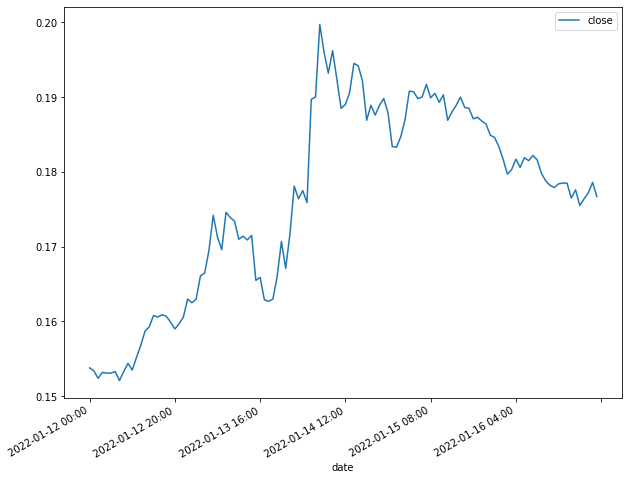

In [15]:
# Plot the doge_price_data for date and close columns
price_data.plot(x='date', y=['close'], figsize=(10, 8))
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# Plot the hour sentiment dataframe
hour_df.plot(x='date', y='compound', figsize=(10, 8))
plt.gcf().autofmt_xdate()
plt.show()

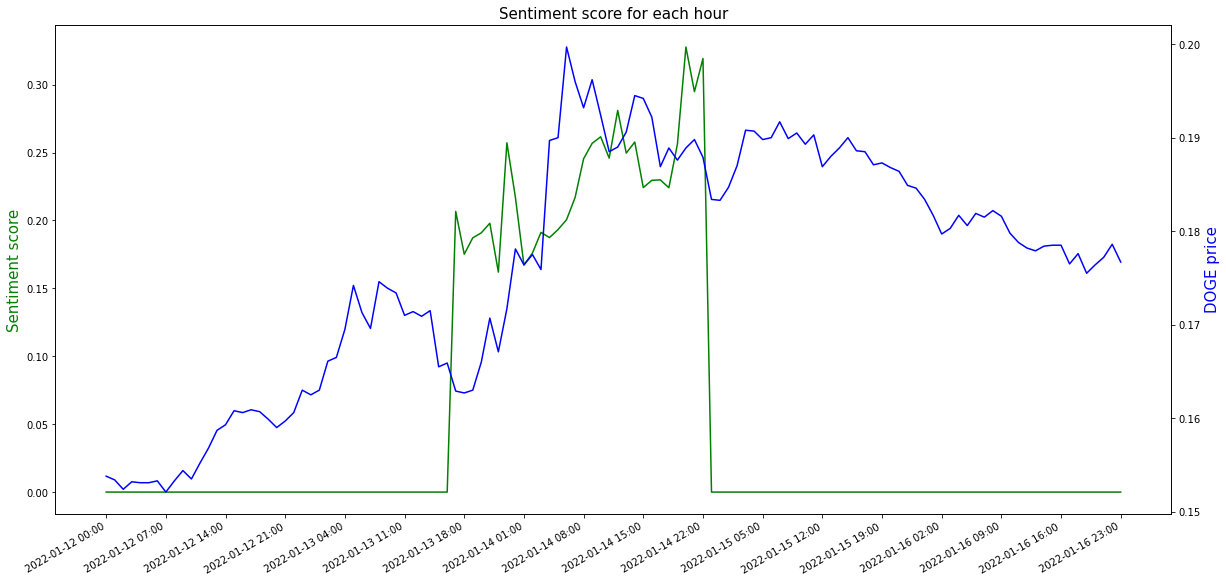

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title('Sentiment score for each hour', fontsize=15)
ax.tick_params(labelsize=10)

ax2 = ax.twinx()
ax.plot(price_data['date'], merged_df['compound'], color='green')
ax2.plot(price_data['date'], price_data['close'], color='blue')

ax.set_ylabel('Sentiment score', fontsize=15, color='green')
ax2.set_ylabel('DOGE price', fontsize=15, color='blue')

ax.set_xticks(ax.get_xticks()[::7])

plt.gcf().autofmt_xdate()
plt.show()


### Cross-Correllation analysis
Applying a correlation on the series (tweets' scores and crypto currency) is not enough. That's why we need cross-correlation. The difference is that cross-correlation adds a lag which permit to shift one of the timeseries left or right to find, maybe, a better correlation. This is coherent with our problem as the currency changes come after the tweets' sentiments. So we are fully allowed to operate it.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

In [22]:
# Define the cross-correlation function. 
# The function takes two arguments, x and y, and returns the correlation coefficient.
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

In [ ]:
xcov = [crosscorr(merged_df['sentiment'], price_data['close'], lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize data

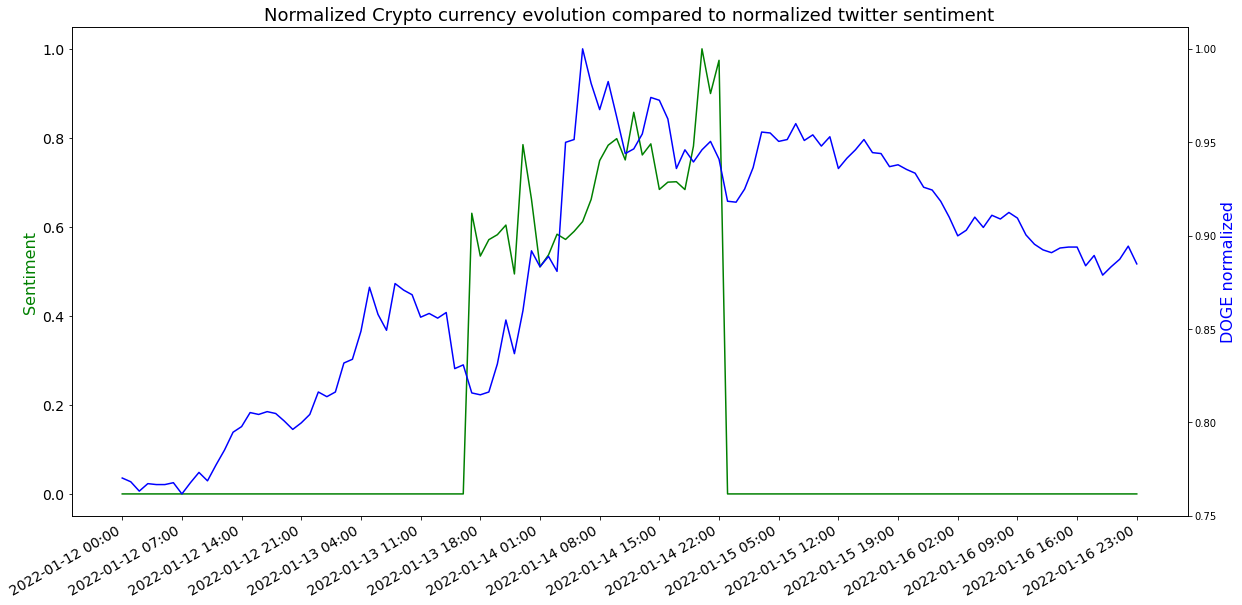

In [24]:
tweets_grouped = merged_df['sentiment'] / max(merged_df['sentiment'].max(), abs(merged_df['sentiment'].min()))
crypto_usd_grouped = price_data['close'] / max(price_data['close'].max(), abs(price_data['close'].min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(price_data['date'], tweets_grouped, 'g-')
ax2.plot_date(price_data['date'], crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("DOGE normalized", color='b', fontsize=16)

ax1.set_xticks(ax1.get_xticks()[::7])

plt.gcf().autofmt_xdate()
plt.show()

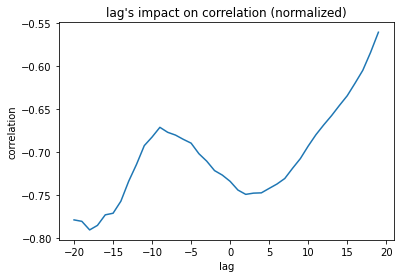

In [25]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Apply the PELT algorithm to the complete data set

Source: https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/

In [43]:
# RUPTURES PACKAGE. 
import ruptures as rpt

# merged_df = pd.merge(hour_df, price_data, on='date', how='outer')
# # # Drop the 'Unamed: 0' column
# merged_df.drop(columns=['Unnamed: 0'], inplace=True)
# merged_df.fillna(0, inplace=True)

# print(merged_df.head())

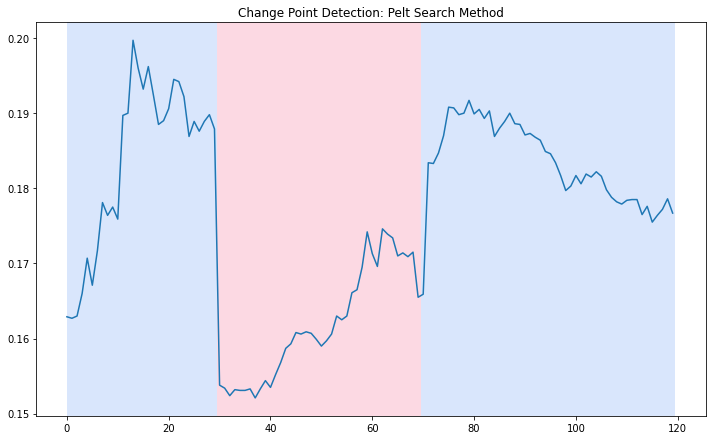

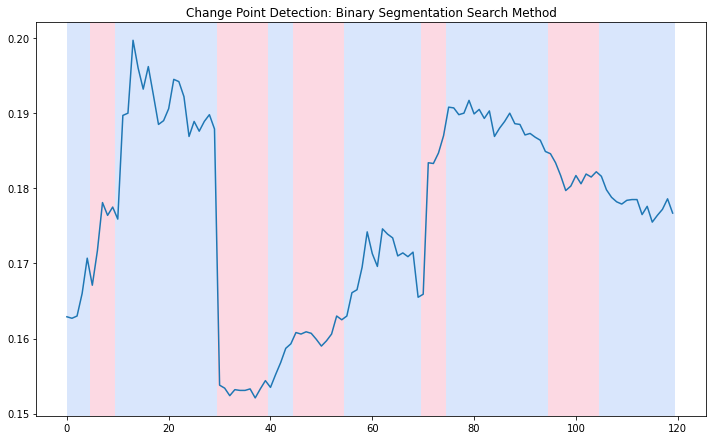

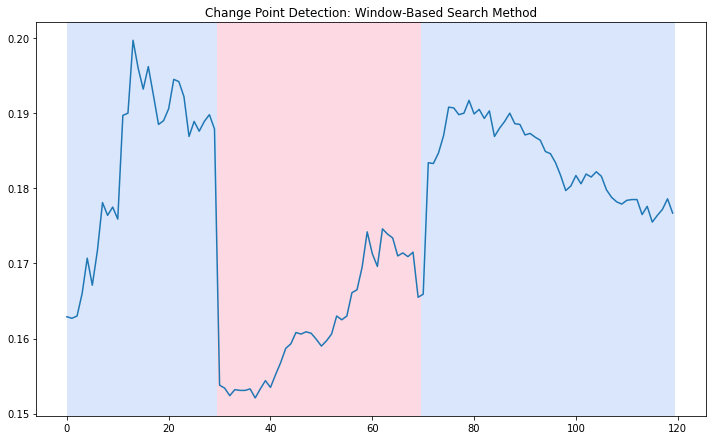

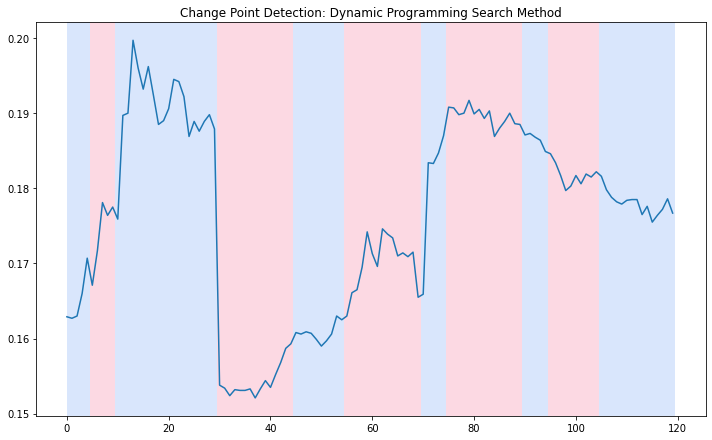

In [45]:
def retrieve_time_series(api, series_ID):
    """ Retrieve time series data from the API.
    Parameters
    —------—
    api : API object
    series_ID : string, ID of the time series
    """

    series_search = api.data_by_series(series=series_ID)
    df = pd.DataFrame(series_search)

    return df

###############################################################################

merged_df.rename(columns={'date':'Date'}, inplace=True)
# Create a copy of merged_df to price_df
price_df = merged_df.copy()

# Process the dataframe and convert the close column to numpy array
points=np.array(price_df['close'])


# The Pelt search method is the most efficient, but requires the user to specify
# the number of breakpoints.

# The Binary Segmentation search method is the most efficient, but requires the
# user to specify the number of breakpoints.

# The 'dynamic' method, which uses a fixed window size and a fixed number of
# breakpoints, but also allows for the removal of outliers.


# Changepoint detection with the Pelt search method. 
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
    
# Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()

# Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()